# RFM Segmentation for retail customers

Segmentation of non-corporate customers according to their transactional activity. customer data is limited to 6 months transactional history.

Variables used:

- Transaction Recency - this refers to the total days since the customer carried out a transaction

- Transaction Frequency - this refers to the total number of unique transaction done by the customer within the 6-months period

- Transaction Monetary Value - this refers to the total amount (value) of transaction done by the customer within the 6- months period.

### **Getting required packages**

Here we load the packages and required libraries for the project.

Note:  I had to comment out lines to to load the _**pyodbc**_ and \_**pandasq**\_l packages since this is just a demo using csv data as input.

_<mark>I had loaded the data from MSSQL database and automated a pipleline to repeat this data load every 6-months. Using the job feature on Azure Databricks</mark>_

In [52]:
#Import Packages
import pandas as pd # working with data
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sns

#!pip install -U pyodbc
import pyodbc
import sys

## Importing pandasql 
#!pip install -U pandasql  - this was used in connecting to MSSQL database in production, but would not be required for this public use.
import pandasql as psql
from pandasql import sqldf 


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

print('Python: ' + sys.version.split('|')[0])
print('Pandas: ' + pd.__version__)
print('pyODBC: ' + pyodbc.version)

Python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.4.4
pyODBC: 4.0.34


## Load 6-months transacntion history as input dataset

In [53]:
#import data from csv to dataframe using pandas..
df = pd.read_csv('dataset\seg_RFM_df.csv')
df.drop_duplicates()

,Unnamed: 0,CustId,Frequency,Recency,Monetary,DateLoaded
0,0,15199727,1624,26,5.933760e+07,2022-12-25 10:16:04.026666
1,1,213865,2852,6,7.009621e+07,2022-12-25 10:16:04.026666
2,2,15284766,5887,3,1.666437e+08,2022-12-25 10:16:04.026666
3,3,15908036,124,72,7.590200e+05,2022-12-25 10:16:04.026666
4,4,14471235,5390,10,9.211388e+07,2022-12-25 10:16:04.026666
...,...,...,...,...,...,...
1184477,1184477,15468053,11252,11,6.646246e+08,2022-12-25 10:16:04.026666
1184478,1184478,14039494,12688,3,7.567593e+08,2022-12-25 10:16:04.026666
1184479,1184479,63534,183,73,0.000000e+00,2022-12-25 10:16:04.026666
1184480,1184480,1300327,63379,3,4.904952e+09,2022-12-25 10:16:04.026666


## Brief EDA on dataset

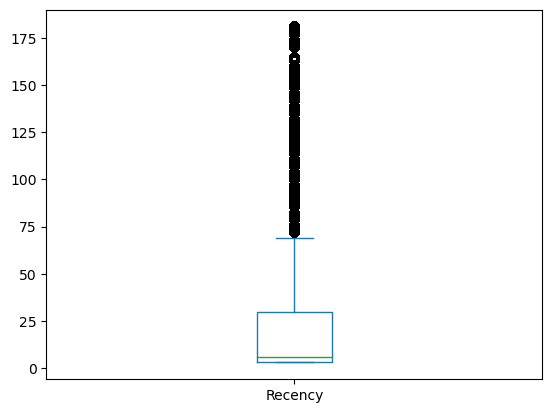

In [54]:
df['Recency'].plot.box() 
plt.show()

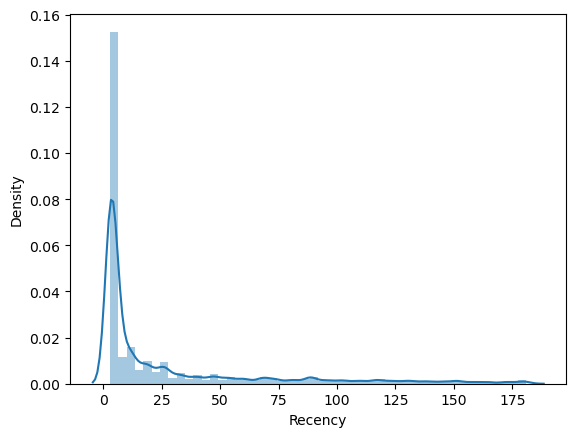

In [55]:
sns.distplot(df['Recency'])
#plt.savefig('plt/DaysSinceLastTx.png')

plt.show()

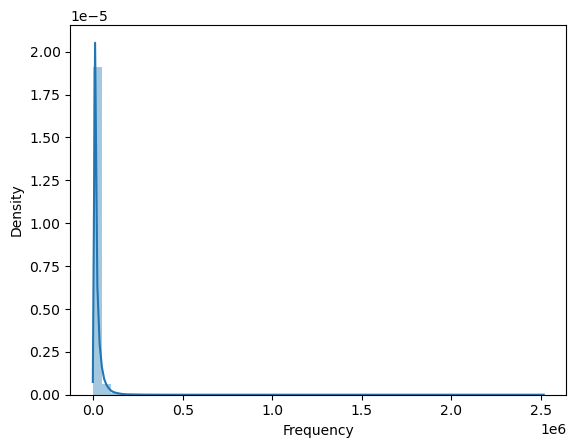

In [56]:
sns.distplot(df['Frequency'])
#plt.savefig('plt/txcount.png')

plt.show()

In [57]:
sns.distplot(df['Monetary'])
#plt.savefig('plt/revenue.png')

plt.show()

## Preprocessing of dataset for modelling

In [ ]:
sdf =  psql.sqldf("select CustId, Recency, Frequency, Monetary from df")
sdf.head()

,CustId,Recency,Frequency,Monetary
0,15199727,26,1624,5.933760e+07
1,213865,6,2852,7.009621e+07
2,15284766,3,5887,1.666437e+08
3,15908036,72,124,7.590200e+05
4,14471235,10,5390,9.211388e+07


In [ ]:
rfm = sdf

## Clustering by RFM

In [ ]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 3.0, 0.4: 4.0, 0.6: 12.0, 0.8: 45.0},
 'Frequency': {0.2: 244.0, 0.4: 1330.0, 0.6: 4368.0, 0.8: 13320.0},
 'Monetary': {0.2: 1473614.304000001,
  0.4: 12987979.0,
  0.6: 43794313.79999999,
  0.8: 155974338.10000005}}

In [ ]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [ ]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [ ]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustId,Recency,Frequency,Monetary,R,F,M,RFM Score
0,15199727,26,1624,5.933760e+07,2,3,4,234
1,213865,6,2852,7.009621e+07,3,3,4,334
2,15284766,3,5887,1.666437e+08,5,4,5,545
3,15908036,72,124,7.590200e+05,1,1,1,111
4,14471235,10,5390,9.211388e+07,3,4,4,344


In [ ]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustId,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,15199727,26,1624,5.933760e+07,2,3,4,234,At Risk
1,213865,6,2852,7.009621e+07,3,3,4,334,Need Attention
2,15284766,3,5887,1.666437e+08,5,4,5,545,Champions
3,15908036,72,124,7.590200e+05,1,1,1,111,Hibernating
4,14471235,10,5390,9.211388e+07,3,4,4,344,Loyal Customers


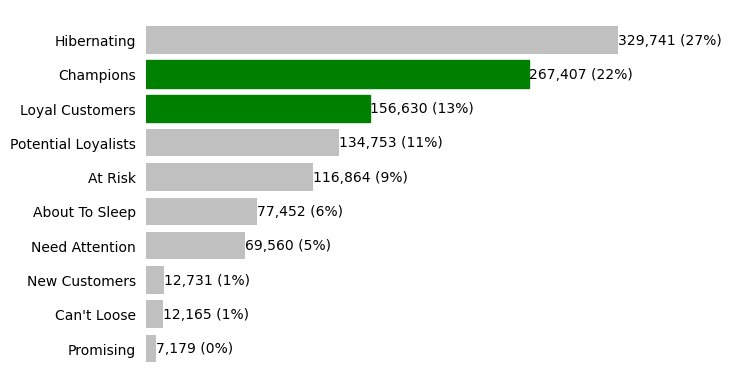

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Champions', 'Loyal Customers']:
            bar.set_color('green')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
#plt.savefig('plt/rfmsegments.png')

plt.show()

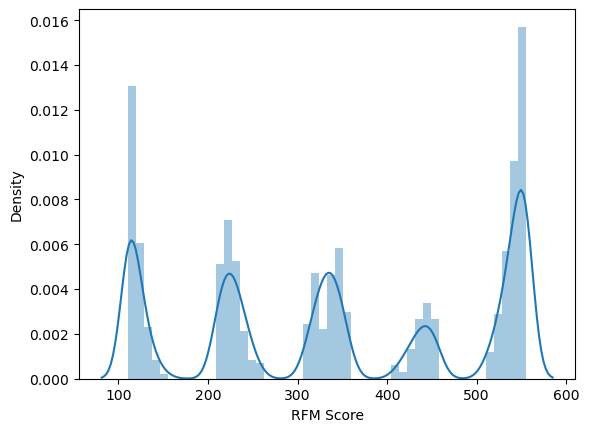

In [ ]:
# Distribution of the RFM Segments

sns.distplot(rfm['RFM Score'])
#plt.savefig('plt/rfm_score.png')

plt.show()

I also discovered customer lifetime can also skew recency and frequency causing outliers,, you know older customer will naturally have high frequency, while new customers would naturally have good recency

## Description of RFM clusters


| Segment |  Description|
|--|--|
| Champions |  Transacted recently, and often and profitable customers		
|  Loyal Customers|            Our hot high profitable customers, transacting frequently and recently.  |
|Potential Loyalist|Recent customers with average frequency in transaction|
|New Customers	| Recently transacted, but not frequently. |
| Promising |  Recently transacted, but returns low monetary value |
|Customers Needing Attention|Above average recency, frequency and monetary values. May not have transacted very recently                                 though.|
| About To Sleep | Below average recency and frequency. Will lose them if not reactivated |
| At Risk | Below average recency and frequency. Will lose them if not reactivated. |
|Can't Loose|History of frequent transaction but no recency|
| Hibernating | Last transaction was a long time ago |

## Processing clustering results

In [ ]:

#rfm.to_csv('clustering_result\rfm_clusters.csv')

rfm.head()

,CustId,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,15199727,26,1624,5.933760e+07,2,3,4,234,At Risk
1,213865,6,2852,7.009621e+07,3,3,4,334,Need Attention
2,15284766,3,5887,1.666437e+08,5,4,5,545,Champions
3,15908036,72,124,7.590200e+05,1,1,1,111,Hibernating
4,14471235,10,5390,9.211388e+07,3,4,4,344,Loyal Customers


In [ ]:
output_table =  psql.sqldf("""
                
    SELECT *, Segment,

    CASE	
		WHEN [RFM Score] >= 500 THEN 'Champion Caleb' 
		WHEN [RFM Score] >= 400 THEN 'Promising Peter' 
		WHEN [RFM Score] >= 300 THEN 'Lukewarm Jude' 
		WHEN [RFM Score] >= 200 THEN 'Cold Clara' 
		WHEN [RFM Score] <200 THEN 'Dormant Dora' 
    END AS [Cluster]
    
   -- Segment



    FROM rfm

                  """)


sdf2 = output_table
sdf2['RunDate'] = pd.to_datetime('today')





In [ ]:
#sdf2.to_csv('clustering_result\rfm_slim_clusters.csv')
sdf2.head()

,CustId,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,RunDate
0,15199727,26,1624,5.933760e+07,2,3,4,234,At Risk,Cold Clara,2022-12-25 13:08:37.045554
1,213865,6,2852,7.009621e+07,3,3,4,334,Need Attention,Lukewarm Jude,2022-12-25 13:08:37.045554
2,15284766,3,5887,1.666437e+08,5,4,5,545,Champions,Champion Caleb,2022-12-25 13:08:37.045554
3,15908036,72,124,7.590200e+05,1,1,1,111,Hibernating,Dormant Dora,2022-12-25 13:08:37.045554
4,14471235,10,5390,9.211388e+07,3,4,4,344,Loyal Customers,Lukewarm Jude,2022-12-25 13:08:37.045554
